## Barrier Option Pricing Sample Notebook
G Onodi, Oct 7 2020

This notebook demonstrates pricing methodologies for a down-and-in barrier option. First, we begin with a discussion of the key product characteristics of barrier options, and continue with an example of pricing. We continue the discussion with an extension to a multi-asset group of underlyings.

__Table of Contents:__
1. Pricing Single-Asset Barrier Options: Monte Carlo Approach
2. Backtesting simulated prices against plain-vanilla put
3. Barrier Put Option - Analytic Solution
4. Extension to Barrier Option Problem: Multi-Asset Underlying


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import gauss
from math import exp, sqrt, log as ln
from datetime import date
from IPython.display import Latex
from scipy.stats import norm
N = norm.cdf


class BarrierMC():
    """ Barrier option pricing using simulation """

    def __init__(self, S, vol, K, r, issue_dt, mat_dt, B=None):
        self.S = S
        self.vol = vol
        self.r = r
        self.issue_dt = issue_dt
        self.mat_dt = mat_dt
        self.K = K
        self.barrier = B
        self.timestep = 1/365.
        self.T = (pd.Period(self.mat_dt) - pd.Period(self.issue_dt)).n * self.timestep
    
    @staticmethod
    def _get_barrier_put_payoff_downin(K, s, B):
        if s <= B['DI']:
            payoff = max(K - s, 0.0)
        else:
            payoff = 0
        return payoff
    
    @staticmethod
    def _get_barrier_put_payoff_downout(K, s, B):
        if s <= B['DO']:
            payoff = 0
        else:
            payoff = max(K - s, 0.0)
        return payoff
    
    def put_payoff(self, s):
        if self.barrier is not None:
            if 'DI' in self.barrier.keys():
                payoff = self._get_barrier_put_payoff_downin(self.K, s, self.barrier)
            elif 'DO' in self.barrier.keys():
                payoff = self._get_barrier_put_payoff_downout(self.K, s, self.barrier)
        else:
            payoff = max(K - s, 0.0)
        return payoff

    def simulate(self, num_paths):
        paths, payoffs = [], []
        for i in range(num_paths):
            path = []
            N = int(self.T / self.timestep)
            price = self.S
            for j in range(0, N-1):
                price *= exp( (self.r - 0.5 * self.vol**2) * self.timestep + self.vol * sqrt(self.timestep) * gauss(0, 1.0))
                path.append(price)
            paths.append(path)
            payoffs.append(self.put_payoff(path[-1])) # Use S_T for V(S,T)
        self.simulated_paths = paths
        self.simulated_payoffs = payoffs
        
        payoffarr = np.array(payoffs, dtype=float)
        DF = exp(-self.r * self.T)
        pv_payoff = payoffarr * DF
        price = np.average(pv_payoff)
        stddev = np.std(pv_payoff)
        conf_int_lower = price - 1.96 * stddev/sqrt(num_paths)
        conf_int_upper = price + 1.96 * stddev/sqrt(num_paths)
        return {'price': price, 'conf_int_upper': conf_int_upper, 
                'conf_int_lower': conf_int_lower,'std. dev.': stddev}
        
    def plot_paths(self, highlight_itm=False, **kwargs):
        paths = self.simulated_paths
        fig, ax = plt.subplots(nrows=1, ncols=2,sharey=True, figsize=(8, 4), gridspec_kw={'width_ratios': [4, 1]})
        df1 = pd.DataFrame(paths).transpose()
        df = df1.iloc[:, :2000]
        colors = pd.Series(self.simulated_payoffs).iloc[:2000]
        colors=pd.Series(bmc.simulated_payoffs).apply(lambda x: 'green' if x > 0.0 else 'grey').values
        df.plot(ax=ax[0], linewidth=0.5, legend=False, color=colors, **kwargs)
        df1.iloc[-1, :].hist(ax=ax[1], orientation="horizontal", bins=50)
        ax[1].grid(False)
        ax[0].set_ylabel('Price')
        ax[0].set_xlabel('Time')
        plt.tight_layout()
        return ax


### 1. Pricing Single-Asset Barrier Put Option: Simulation Approach

Assumptions:
* Underlying $S$ follows a geometric Brownian motion $dS_t = \alpha S_{t}dt + \sigma S_tdW^P_t$ where $W^P_t$ denotes a standard brownian motion.
* Constant vol, $\sigma$
* Const dividend yield, $D=0$
* Constant risk free rate, $r$
* Payoff follows "Down-and-In" put option, with strike price $K$ equal to initial fixing price $S$ (ATM), and barrier level $S_B$ set at a fixed percentage $B$ (e.g. 55%) of the initial fixing price. Option comes into effect if __on the Barrier Observation Date (Apr 23 2021)__ $S$ is at or below $S_B$, otherwise expires worthless as shown in the boundary conditions below.
$$
\begin{equation}
  V(S,T) =
    \begin{cases}
      S-K & \text{if $S_T \leq S_B$}\\
      0 & \text{if $S_T > S_B$}\\
    \end{cases}       
\end{equation}
$$

Solution involves $0\leq S \leq S_B$

{'price': 0.133420089265053,
 'conf_int_upper': 0.13978774273775083,
 'conf_int_lower': 0.12705243579235517,
 'std. dev.': 0.7264543888834158}

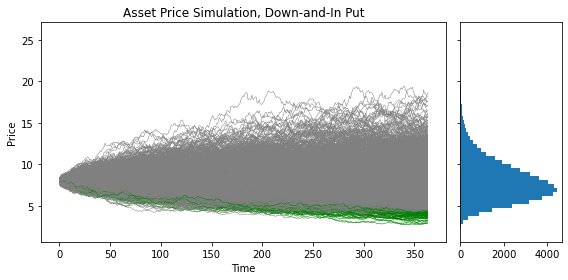

In [2]:
S = 7.976
vol = 0.30
r = 0.001
issue_dt = '2020-04-30'
mat_dt   = '2021-04-30'
K = S * 1.
B = {'DI': S * .55}

bmc = BarrierMC(S=S, vol=vol, K=K, B=B, r=r, issue_dt=issue_dt, mat_dt=mat_dt)
res = bmc.simulate(num_paths=50000)
ax=bmc.plot_paths(title="Asset Price Simulation, Down-and-In Put")
down_and_in_price = res['price']
res

{'price': 0.8059450570640934,
 'conf_int_upper': 0.8149632740332932,
 'conf_int_lower': 0.7969268400948936,
 'std. dev.': 1.0288441928047407}

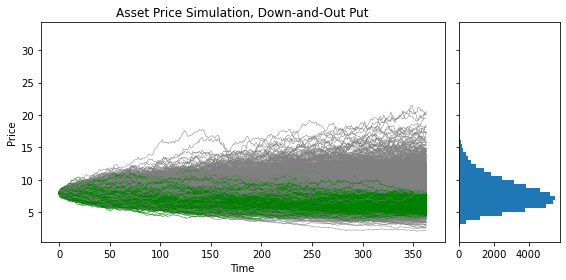

In [3]:
S = 7.976
vol = 0.30
r = 0.001
issue_dt = '2020-04-30'
mat_dt   = '2021-04-30'
K = S * 1.
B = {'DO': S * .55}

bmc = BarrierMC(S=S, vol=vol, K=K, B=B, r=r, issue_dt=issue_dt, mat_dt=mat_dt)
res = bmc.simulate(num_paths=50000)
bmc.plot_paths(title="Asset Price Simulation, Down-and-Out Put")
down_and_out_price = res['price']
res

Payoff structure for option:

Text(0.5, 0, 'Underlying Price')

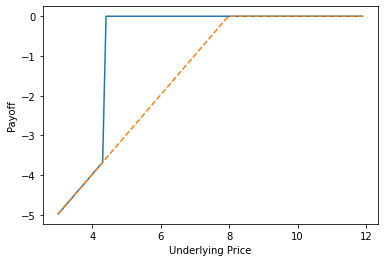

In [4]:
l = []
for s in range(30, 120):
    l.append(BarrierMC._get_barrier_put_payoff_downin(S*1., s/10, {'DI': S*.55}))
(-pd.Series(l, index=[x/10 for x in range(30,120)])).plot()

l = []
for s in range(30, 120, 1):
    l.append(BarrierMC._get_barrier_put_payoff_downin(S*1., s/10, {'DI': S*1.}))
ax=(-pd.Series(l, index=[x/10 for x in range(30,120)])).plot(linestyle='--')
ax.set_ylabel('Payoff')
ax.set_xlabel('Underlying Price')


### 2. Backtesting simulated prices against plain-vanilla put

$C(S_t, t) = S_{t}N(d_1)-K\exp(-r(T-t))N(d_2)$

$P(S_t, t) = K\exp(-r(T-t))N(-d_2)-S_tN(-d_1)$

$d_1=\frac{\ln\left(\frac{S_t}{K}\right)+\left(r+\frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T-t}}$

$d_2=d_1-\sigma\sqrt{T-t}$


In [5]:
def blackscholes_put(T, S, K, r, vol):
    d1 = (ln(S/K) + (r + 0.5 * vol ** 2)*(T)) / (vol * T ** 0.5)
    d2 = (ln(S/K) + (r - 0.5 * vol ** 2)*(T)) / (vol * T ** 0.5)
    price = K * exp(-r*(T)) * N(-d2) - S*N(-d1)
    return price

T = 1.
price = blackscholes_put(T, S, K, r, vol)

print("Down-and-In Barrier (MC method): \t\t", down_and_in_price)
print("Down-and-Out Barrier (MC method): \t\t", down_and_out_price)
print("\nDown-In + Down-Out combined (MC method): \t", down_and_in_price + down_and_out_price)
print("Plain-Vanilla Put (Analytic method): \t\t", price)
print('='*80)

Down-and-In Barrier (MC method): 		 0.133420089265053
Down-and-Out Barrier (MC method): 		 0.8059450570640934

Down-In + Down-Out combined (MC method): 	 0.9393651463291464
Plain-Vanilla Put (Analytic method): 		 0.9465653903065667


### 3. Barrier Put Option - Analytic Solution

Per Wilmott (2006), the closed-form solutions for a barrier option are given below.

$
a = \left( \frac{S_b}{S} \right)^{-1+(2(r-q)/\sigma^2)} \\ 
b = \left( \frac{S_b}{S} \right)^{1+(2(r-q)/\sigma^2)}
$

Where $q$ is the dividend yield.

$
d_1 = \frac{\log{(S/K)} + \left(r-q+\frac{1}{2}\sigma^2\right)(T-t)}{\sigma\sqrt{T-t}} \\
d_2 = \frac{\log{(S/K)} + \left(r-q-\frac{1}{2}\sigma^2\right)(T-t)}{\sigma\sqrt{T-t}} \\
d_3 = \frac{\log{(S/S_b)} + \left(r-q+\frac{1}{2}\sigma^2\right)(T-t)}{\sigma\sqrt{T-t}} \\
d_4 = \frac{\log{(S/S_b)} + \left(r-q-\frac{1}{2}\sigma^2\right)(T-t)}{\sigma\sqrt{T-t}} \\
d_5 = \frac{\log{(S/S_b)} - \left(r-q-\frac{1}{2}\sigma^2\right)(T-t)}{\sigma\sqrt{T-t}} \\
d_6 = \frac{\log{(S/S_b)} - \left(r-q+\frac{1}{2}\sigma^2\right)(T-t)}{\sigma\sqrt{T-t}} \\
d_7 = \frac{\log{(SK/S_b^2)} - \left(r-q-\frac{1}{2}\sigma^2\right)(T-t)}{\sigma\sqrt{T-t}} \\
d_8 = \frac{\log{(SK/S_b^2)} - \left(r-q+\frac{1}{2}\sigma^2\right)(T-t)}{\sigma\sqrt{T-t}} \\
$

Down-and-in put:

$V(S,T)=-Se^{-q(T-t)}(1-N(d_3)+b(N(d_8)-N(d_6))) + Ke^{-r(T-t)}(1-N(d_4)+a(N(d_7)-N(d_5)))$

In [6]:
def barrier_put_analytic(S, sigma, r, q, T, _t, K, S_b, b_type='DI'):
    a = (S_b/S)**(-1+(2*(r-q)/(sigma**2)))
    b = (S_b/S)**(1+(2*(r-q)/(sigma**2)))
    
    d1 = (np.log(S/K)+(r-q+(0.5)*sigma**2)*(T-_t)) / (sigma*sqrt(T-_t))
    d2 = (np.log(S/K)+(r-q-(0.5)*sigma**2)*(T-_t)) / (sigma*sqrt(T-_t))
    d3 = (np.log(S/S_b)+(r-q+(0.5)*sigma**2)*(T-_t)) / (sigma*sqrt(T-_t))
    d4 = (np.log(S/S_b)+(r-q-(0.5)*sigma**2)*(T-_t)) / (sigma*sqrt(T-_t))
    d5 = (np.log(S/S_b)-(r-q-(0.5)*sigma**2)*(T-_t)) / (sigma*sqrt(T-_t))
    d6 = (np.log(S/S_b)-(r-q+(0.5)*sigma**2)*(T-_t)) / (sigma*sqrt(T-_t))
    d7 = (np.log((S*K)/S_b**2)-(r-q-(0.5)*sigma**2)*(T-_t)) / (sigma*sqrt(T-_t))
    d8 = (np.log((S*K)/S_b**2)-(r-q+(0.5)*sigma**2)*(T-_t)) / (sigma*sqrt(T-_t))
    
    if b_type == 'DI':
        v = -S*exp(-q*(T-_t))*(1-N(d3)+b*(N(d8)-N(d6))) + K*exp(-r*(T-_t))*(1-N(d4)+a*(N(d7) - N(d5)))
    elif b_type == 'DO':
        v = -S*exp(-q*(T-_t))*(N(d3)-N(d1)-b*(N(d8)-N(d6))) + K*exp(-r*(T-_t))*(N(d4)-N(d2)-a*(N(d7)-N(d5)))
    return v

Price Down-and-In:		 0.22047098298401663 
Price Down-and-Out:		 0.7260944073225493 
Price (DownIn + DownOut):	 0.9465653903065658 
Price Plain-Vanilla Put:	 0.9465653903065667


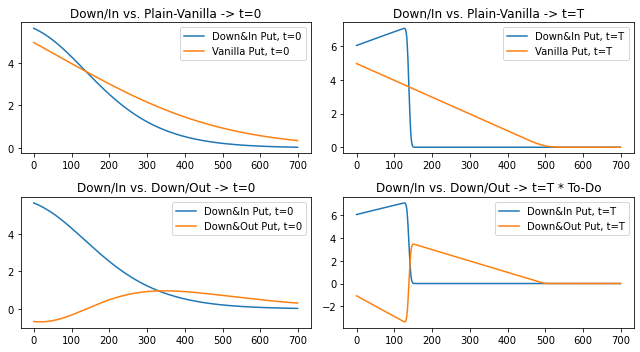

In [7]:
S = 7.976
sigma = 0.30
r = 0.001
q = 0.
T = 1
_t = 0
K = S * 1.
S_b = S * .55

price_DI = barrier_put_analytic(S, sigma, r, q, T, _t, K, S_b, b_type='DI')
price_DO = barrier_put_analytic(S, sigma, r, q, T, _t, K, S_b, b_type='DO')
price_put = blackscholes_put(T, S, K, r, sigma)
print("Price Down-and-In:\t\t", price_DI, 
      "\nPrice Down-and-Out:\t\t", price_DO, 
      "\nPrice (DownIn + DownOut):\t", price_DI+price_DO,
      "\nPrice Plain-Vanilla Put:\t", price_put)

v, v1, v2, v3, v4, v5, v6, v7 = [], [], [], [], [], [], [], []
for S in range(300, 1000):
    price=barrier_put_analytic(S/100, sigma, r, q, T, _t, K, S_b, b_type='DI')
    v.append(price)
    price=barrier_put_analytic(S/100, sigma, r, q, T, 0.5, K, S_b, b_type='DI')
    v1.append(price)
    price=barrier_put_analytic(S/100, sigma, r, q, T, 0.999, K, S_b, b_type='DI')
    v2.append(price)
    price=barrier_put_analytic(S/100, sigma, r, q, T, 0.999, K, S_b, b_type='DO')
    v3.append(price)
    price=blackscholes_put(1, S/100, K, r, sigma)
    v4.append(price)
    price=blackscholes_put(0.01, S/100, K, r, sigma)
    v5.append(price)
    price=barrier_put_analytic(S/100, sigma, r, q, T, _t, K, S_b, b_type='DO')
    v6.append(price)
    price=barrier_put_analytic(S/100, sigma, r, q, T, 0.999, K, S_b, b_type='DO')
    v7.append(price)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9, 5))
pd.Series(v, name="Down&In Put, t=0").plot(legend=True, ax=ax.flatten()[0], title='Down/In vs. Plain-Vanilla -> t=0')
pd.Series(v4, name="Vanilla Put, t=0").plot(legend=True, ax=ax.flatten()[0])

pd.Series(v2, name="Down&In Put, t=T").plot(legend=True, ax=ax.flatten()[1], title='Down/In vs. Plain-Vanilla -> t=T')
pd.Series(v5, name="Vanilla Put, t=T").plot(legend=True, ax=ax.flatten()[1])

pd.Series(v, name="Down&In Put, t=0").plot(legend=True, ax=ax.flatten()[2], title='Down/In vs. Down/Out -> t=0')
pd.Series(v6, name="Down&Out Put, t=0").plot(legend=True, ax=ax.flatten()[2])

pd.Series(v2, name="Down&In Put, t=T").plot(legend=True, ax=ax.flatten()[3], title='Down/In vs. Down/Out -> t=T * To-Do')
pd.Series(v7, name="Down&Out Put, t=T").plot(legend=True, ax=ax.flatten()[3])

plt.tight_layout()


### 4. Extension to Barrier Option Problem: Multi-Asset Underlying

We can extend our example above of the single-asset barrier option to multiple correlated underlyings. To simulate the asset paths, we need to establish correlated underlying prices for the simulation. 

Assumptions:
* Underlying $S^1$ and $S^2$ follow geometric Brownian motions with correlation $\rho$:

$
dS^1_t = \alpha S_{t}dt + \sigma S_tdW^1_t \\
dS^2_t = \alpha S_{t}dt + \sigma S_tdW^2_t$

where

$
W^1_t \sim \mathcal{N}(0, \sqrt{dt}) \\ 
W^2_t = \rho W^1_t + \sqrt{1-\rho^2}Z_t
$ 

where $Z_t$ denotes a brownian motion independent of $dW^1_t$.
* Payoff follows "Down-and-In" put option, with strike price $K$ equal to initial fixing price $S$ (ATM), and barrier level $S_B$ set at a fixed percentage $B$ (e.g. 55%) of the initial fixing price. Option comes into effect if __on the Barrier Observation Date (Apr 23 2021)__ $S$ is at or below $S_B$, otherwise expires worthless as shown in the boundary conditions below.
$$
\begin{equation}
  V(S,T) =
    \begin{cases}
      S_{worst} * ratio_{worst} & \text{if $S_T \leq S_B$}\\
      0 & \text{if $S_T > S_B$}\\
    \end{cases}       
\end{equation}
$$

Solution involves $0\leq S \leq S_B$.



In [8]:
class BarrierMultiMC():
    """ Multi-Asset Barrier option pricing using simulation """

    def __init__(self, asset1, asset2, rho, r, issue_dt, mat_dt):
        self.asset1 = asset1
        self.asset2 = asset2
        self.r = r
        self.issue_dt = issue_dt
        self.mat_dt = mat_dt
        self.timestep = 1/365.
        self.T = (pd.Period(self.mat_dt) - pd.Period(self.issue_dt)).n * self.timestep
        self.rho = rho
        
    def multi_payoff(self, price1, price2):
        if (price1 < self.asset1['B']['DO']) or (price2 < self.asset2['B']['DO']):
            perf_1 = price1 / self.asset1['K']
            perf_2 = price2 / self.asset2['K']
            if perf_1 < perf_2: # Worst-Performing Underlying
                return price1 * self.asset1['ratio']
            else:
                return price2 * self.asset2['ratio']
        else:
            return 0
    
    def simulate(self, num_paths):
        paths1, paths2, payoffs = [], [], []
        for i in range(num_paths):
            path1, path2 = [], []
            N = int(self.T / self.timestep)
            price1 = self.asset1['S']
            price2 = self.asset2['S']
            for j in range(0, N-1):
                dW1 = np.random.normal(0, np.sqrt(self.timestep), 1)
                dW2 = self.rho * dW1 + np.sqrt(1 - self.rho **2) * np.random.normal(0, np.sqrt(self.timestep), 1)
                price1 *= exp( (self.r - 0.5 * self.asset1['vol']**2) * self.timestep + self.asset1['vol'] * dW1)
                price2 *= exp( (self.r - 0.5 * self.asset1['vol']**2) * self.timestep + self.asset1['vol'] * dW2)
                path1.append(price1)
                path2.append(price2)
            paths1.append(path1)
            paths2.append(path2)
            payoffs.append(self.multi_payoff(path1[-1], path2[-1])) # Use S_T for V(S,T)
        self.simulated_paths1 = paths1
        self.simulated_paths2 = paths2
        self.simulated_payoffs = payoffs
        
        payoffarr = np.array(payoffs, dtype=float)
        DF = exp(-self.r * self.T)
        pv_payoff = payoffarr * DF
        price = np.average(pv_payoff)
        return {'price': price}
    

array([[1.        , 0.74104024],
       [0.74104024, 1.        ]])

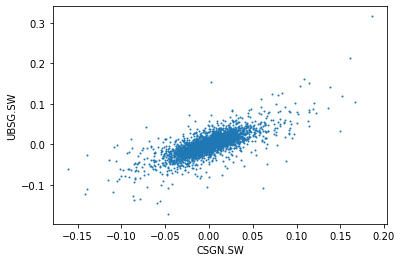

In [9]:
import yfinance
import seaborn as sns
data = yfinance.download(["CSGN.SW", "UBSG.SW"], "2000-01-01", '2020-01-01', progress=False)
underlyings = data['Adj Close'].fillna(method='ffill').pct_change().dropna()
underlyings.plot.scatter(x="CSGN.SW", y="UBSG.SW", s=1)
rho = np.corrcoef(underlyings["CSGN.SW"].values, underlyings["UBSG.SW"].values)
rho

#### 4.2 Simulate correlated brownian motions and apply payoff function to compute price

In [10]:
asset1 = {
    'S': 7.976,
    'vol': 0.30,
    'K': 7.976,
    'B': {'DO': 7.976 * .55},
    'ratio': 125.3791
}

asset2 = {
    'S': 9.292,
    'vol': 0.30,
    'K': 9.292,
    'B': {'DO': 9.292 * .55},
    'ratio': 107.6195
}

correl = rho[0][1]

iss_dt = '2020-04-30'
mat_dt   = '2021-04-30'
r = 0.001

bmmc = BarrierMultiMC(asset1, asset2, rho=correl, r=r, issue_dt=iss_dt, mat_dt=mat_dt)
bmmc.simulate(num_paths = 10000)



{'price': 24.77585543966508}

#### 4.3 Review simulated asset price distribution for correlation

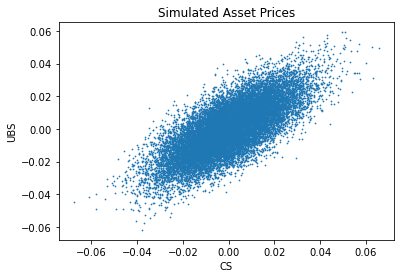

In [11]:
sim1 = pd.Series(bmmc.simulated_paths1[0], name='UBS').pct_change().dropna()
sim2 = pd.Series(bmmc.simulated_paths2[0], name='CS').pct_change().dropna()
df1=pd.concat([sim1, sim2], axis=1).dropna()
ax=df1.plot.scatter(x='CS', y='UBS', s=0.5)

for i in range(1,50):
    sim1 = pd.Series(bmmc.simulated_paths1[i], name='UBS').pct_change().dropna()
    sim2 = pd.Series(bmmc.simulated_paths2[i], name='CS').pct_change().dropna()
    df1=pd.concat([sim1, sim2], axis=1).dropna()
    df1.plot.scatter(x='CS', y='UBS', s=0.5, ax=ax, title='Simulated Asset Prices')
